# <center> Предсказание победителя в Dota 2

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import ujson
import numpy as np
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "../data_folder/raw_data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

In [5]:
column_names = df_train_features.columns
print(*column_names)

game_time game_mode lobby_type objectives_len chat_len r1_hero_id r1_kills r1_deaths r1_assists r1_denies r1_gold r1_lh r1_xp r1_health r1_max_health r1_max_mana r1_level r1_x r1_y r1_stuns r1_creeps_stacked r1_camps_stacked r1_rune_pickups r1_firstblood_claimed r1_teamfight_participation r1_towers_killed r1_roshans_killed r1_obs_placed r1_sen_placed r2_hero_id r2_kills r2_deaths r2_assists r2_denies r2_gold r2_lh r2_xp r2_health r2_max_health r2_max_mana r2_level r2_x r2_y r2_stuns r2_creeps_stacked r2_camps_stacked r2_rune_pickups r2_firstblood_claimed r2_teamfight_participation r2_towers_killed r2_roshans_killed r2_obs_placed r2_sen_placed r3_hero_id r3_kills r3_deaths r3_assists r3_denies r3_gold r3_lh r3_xp r3_health r3_max_health r3_max_mana r3_level r3_x r3_y r3_stuns r3_creeps_stacked r3_camps_stacked r3_rune_pickups r3_firstblood_claimed r3_teamfight_participation r3_towers_killed r3_roshans_killed r3_obs_placed r3_sen_placed r4_hero_id r4_kills r4_deaths r4_assists r4_denies 

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [4]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

#### Обучим случайный лес

In [6]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 27.4 s, sys: 92.3 ms, total: 27.5 s
Wall time: 1.95 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [7]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [8]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [9]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-03-20_21-01-01.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [10]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [11]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 2min 22s, sys: 524 ms, total: 2min 22s
Wall time: 11.3 s


In [12]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [13]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [4]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)
    keys = match.keys()
    print(keys)

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])


In [63]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [72]:
player

{'player_slot': 132,
 'hero_id': 83,
 'hero_name': 'npc_dota_hero_treant',
 'account_id_hash': '116aa09d7684da7a6bc388276b1abd1a',
 'ability_upgrades': [{'ability': 5434, 'time': 285, 'level': 1},
  {'ability': 5436, 'time': 488, 'level': 2},
  {'ability': 5436, 'time': 672, 'level': 3},
  {'ability': 5435, 'time': 913, 'level': 4},
  {'ability': 5437, 'time': 1144, 'level': 5},
  {'ability': 5436, 'time': 1145, 'level': 6},
  {'ability': 5436, 'time': 1360, 'level': 7},
  {'ability': 5435, 'time': 1527, 'level': 8},
  {'ability': 5435, 'time': 1660, 'level': 9},
  {'ability': 6024, 'time': 1687, 'level': 10},
  {'ability': 5435, 'time': 1916, 'level': 11}],
 'obs_placed': 8,
 'sen_placed': 0,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 17,
 'firstblood_claimed': 0,
 'teamfight_participation': 0.217,
 'towers_killed': 0,
 'roshans_killed': 0,
 'observers_placed': 8,
 'stuns': 33.337,
 'max_hero_hit': {'type': 'max_hero_hit',
  'time': 2010.079,
  'max': True,
  'inflict

In [85]:
match

{'game_time': 2049,
 'match_id_hash': '75112757bde649d5cff1c7cd4f1275c6',
 'teamfights': [{'start': 306.755,
   'end': 338.551,
   'last_death': 323.454,
   'deaths': 3,
   'players': [{'deaths_pos': {},
     'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1},
     'item_uses': {},
     'killed': {'npc_dota_hero_faceless_void': 114},
     'deaths': 0,
     'buybacks': 0,
     'damage': 383,
     'healing': 0,
     'gold_delta': 336,
     'xp_delta': 440},
    {'deaths_pos': {},
     'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1},
     'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 458,
     'healing': 0,
     'gold_delta': -10,
     'xp_delta': 76},
    {'deaths_pos': {},
     'ability_uses': {},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 0,
     'healing': 0,
     'gold_delta': 174,
     'xp_delta': 249},
    {'deaths_pos': {},
     'abilit

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [16]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

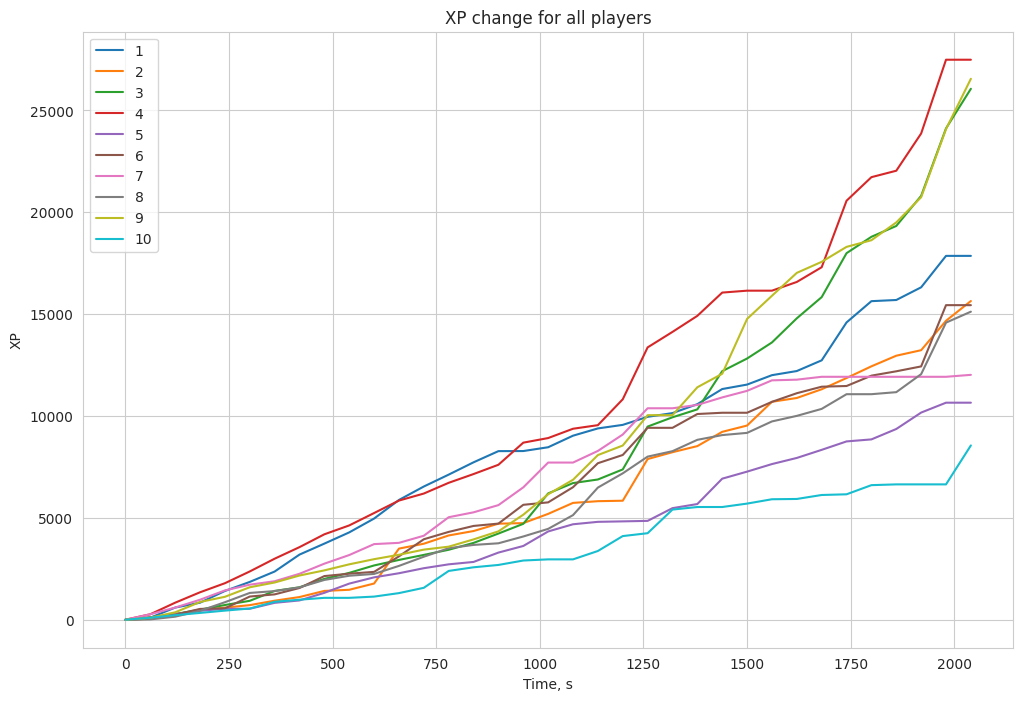

In [17]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [4]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [59]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        radiant_players = match["players"][:5]
        dire_players = match["players"][5:]
        
        # KDA 
        radiant_kda = sum((player["kills"] + player["assists"]) / (player["deaths"] + 1) for player in radiant_players)
        dire_kda = sum((player["kills"] + player["assists"]) / (player["deaths"] + 1) for player in dire_players)
        
        df_features.loc[match_id_hash, "radiant_KDA"] = radiant_kda
        df_features.loc[match_id_hash, "dire_KDA"] = dire_kda
        
        # damage
        radiant_damage = sum(sum(player["damage"].values()) for player in radiant_players)
        dire_damage = sum(sum(player["damage"].values()) for player in dire_players)

        df_features.loc[match_id_hash, "radiant_damage"] = radiant_damage
        df_features.loc[match_id_hash, "dire_damage"] = dire_damage

        # healing
        radiant_healing = sum(sum(player["healing"].values()) for player in radiant_players)
        dire_healing = sum(sum(player["healing"].values()) for player in dire_players)

        df_features.loc[match_id_hash, "radiant_healing"] = radiant_healing
        df_features.loc[match_id_hash, "dire_healing"] = dire_healing


In [60]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [12]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r_level,d_level,r_lh,d_lh,r_gold,d_gold,r_max_mana,d_max_mana,r_health,d_health
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,37.0,30.0,127.0,96.0,18172.0,13144.0,2414.69,2222.69,4498.0,3310.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,5.0,5.0,0.0,0.0,880.0,480.0,1670.69,1586.69,3128.0,3146.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,12.0,11.0,18.0,19.0,2947.0,1843.0,1622.69,1598.69,3343.0,2254.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,48.0,49.0,215.0,165.0,23650.0,20819.0,3226.69,3180.69,4873.0,4817.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,29.0,29.0,141.0,111.0,12628.0,13418.0,2306.69,2222.69,3344.0,3127.0


In [27]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 138 ms, sys: 235 ms, total: 373 ms
Wall time: 20.4 s


In [28]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

***

#### Моё имя в таблице на каггле <font color="brown">**tesselle** </font> (забыла поменять его перед первой подачей и теперь оно не хочет обновляться, извините 😶)

### Построим другие модели

Посмотрим модели на исходном датасете, т.е. безо всяких дополнительных фич (`df_train_features`).

In [4]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

Попробуем поработать с `xgboost`. Я честно пыталась подобрать гиперпараметры через `GridSearchCV`, но когда расчёты перешли порог в десять часов, я психанула и потратила пару часов прекрасного пятничного вечера на ручной подбор гиперпараметров.   
Не отрицаю, автоматический подбор дал бы результат лучше, но и так на удивление неплохо вышло. А я в процессе, кажется, познала дзен.  

P.S. Я слишком поздно поняла, что на самом каггле можно было запускать большие расчёты и вообще не париться...

In [30]:
# param_grid_xgb = {
#     'max_depth': range(1, 10),
#     'n_estimators': range(10, 100, 10),
#     'reg_alpha': range(1, 10),
#     'reg_lambda': range(1, 10),
#     'colsample_bytree': np.linspace(0.5, 1, 10),
#     'subsample': np.linspace(0.5, 1, 10)
# }

# xgb_model = XGBClassifier(n_jobs=-1)

# grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=2)
# grid_search_xgb.fit(X_train, y_train)

# print("Лучшие параметры бустинга от xgboost:", grid_search_xgb.best_params_)

Интересно, что субъективно наиболее важным оказался параметр `n_estimators` - именно его увеличение прям значительно повышало скоры.

In [39]:
xgb_model = XGBClassifier(max_depth=2,
                            n_estimators=1000,
                            min_child_weight=5,
                            learning_rate=0.2,
                            colsample_bytree=0.7,
                            reg_alpha=15,
                            reg_lambda=1
                         )

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
y_pred_xgb = xgb_model.predict_proba(X_valid)[:, 1]

In [41]:
valid_score_xgb = roc_auc_score(y_valid, y_pred_xgb)
print("ROC-AUC score на отложенной части:", valid_score_xgb)  # 0.8052326891261069

valid_accuracy_xgb = accuracy_score(y_valid, y_pred_xgb > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy_xgb)  # 0.7180862250262882

ROC-AUC score на отложенной части: 0.8052326891261069
Accuracy score (p > 0.5) на отложенной части: 0.7180862250262882


К слову, без подбора гиперпараметров всё было совсем грустно:  
ROC-AUC = 0.780026866212312  
Accuracy score (p > 0.5) = 0.6953732912723449

Теперь кросс-валидация:

In [37]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=cv, scoring="roc_auc")

cv_scores_xgb

array([0.80523269, 0.80310749, 0.80043479, 0.80359923, 0.8050759 ])

In [38]:
print(f"Среднее значение ROC-AUC на кросс-валидации для xgboost: {cv_scores_xgb.mean()}")  # 0.803490020443587

Среднее значение ROC-AUC на кросс-валидации для xgboost: 0.803490020443587


Стало немного хуже :(

Я устала подбирать параметры для xgboost, поэтому решила скипнуть проверки со всякими `lightgbm` и `catboost`, потому что 

а) в предыдущем дз скоры для всех этих моделей отличались буквально тысячными долями;  
б) взяла логистическую регрессию и вывела скор **выше** предыдущего буквально за двадцать минут... Просто увеличила количество итераций, чтобы избавиться от ошибки про max iter, и подала `solver='saga'`, т.к. вычитала, что он неплохо подходит для больших данных и у него больше всего поддерживаемых штрафов (supported penalties) по сравнению с аналогами.

In [46]:
logreg = LogisticRegression(max_iter=8000, solver='saga')

In [47]:
%%time
logreg.fit(X_train, y_train)

CPU times: user 4min 27s, sys: 0 ns, total: 4min 27s
Wall time: 4min 28s


LogisticRegression(max_iter=8000, solver='saga')

In [48]:
y_pred_logreg = logreg.predict_proba(X_valid)[:, 1]

In [49]:
valid_score_logreg = roc_auc_score(y_valid, y_pred_logreg)
print("ROC-AUC score на отложенной части:", valid_score_logreg)  # 0.8064875662718826

valid_accuracy_logreg = accuracy_score(y_valid, y_pred_logreg > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy_logreg)  # 0.7199789695057834

ROC-AUC score на отложенной части: 0.8064875662718826
Accuracy score (p > 0.5) на отложенной части: 0.7199789695057834


In [53]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [54]:
%%time
cv_scores_logreg = cross_val_score(logreg, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 749 ms, sys: 429 ms, total: 1.18 s
Wall time: 5min 52s


In [55]:
print(f"Среднее значение ROC-AUC на кросс-валидации для логистической регрессии: {cv_scores_logreg.mean()}")  # 0.8074792900567397

Среднее значение ROC-AUC на кросс-валидации для логистической регрессии: 0.8074794228118012


А вот тут стало лучше с кросс-валидацией! Сохраняемся и пробуем подать это на kaggle.

In [94]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred_logreg = logreg.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred_logreg},
                                 index=df_test_features.index)

In [32]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-03-22_14-49-39.csv


UPD: внезапно скор **0.82240**! Я даже не думала, что он так подскочит на тестовых данных.

### Попробуем теперь добавить немного признаков

Но сначала немного изучим наши данные.

In [61]:
df_train_features_extended.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills,radiant_KDA,dire_KDA,radiant_damage,dire_damage,radiant_healing,dire_healing
count,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,...,31698.000000,31698.000000,31698.000000,31698.00000,31698.000000,31698.000000,3.169800e+04,3.169800e+04,31698.000000,31698.000000
mean,1146.519496,19.583538,4.771563,6.535239,7.358982,51.081614,3.151713,3.273361,4.661998,6.255600,...,0.780933,2.193545,1.980346,0.21320,9.741998,9.766134,2.129861e+05,2.157828e+05,7497.532273,7620.608146
std,766.936655,6.306635,3.260899,6.486933,13.295763,34.573173,3.727116,3.281208,5.207887,8.144267,...,2.436478,2.567384,2.495557,2.67417,7.424689,7.523067,2.220714e+05,2.265526e+05,8556.954804,8844.174356
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-11.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,-1.00000,4.450198,4.333333,4.556875e+04,4.485125e+04,1525.000000,1536.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,0.000000,1.000000,1.000000,0.00000,8.655952,8.566667,1.438560e+05,1.412755e+05,4596.000000,4558.500000
75%,1659.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,0.000000,4.000000,3.000000,1.00000,13.428571,13.574794,3.128492e+05,3.179918e+05,10463.000000,10572.750000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,83.000000,...,47.000000,11.000000,11.000000,11.00000,81.904762,65.338889,2.904638e+06,2.933244e+06,85309.000000,169559.000000


In [62]:
df_train_features_extended.dtypes

game_time            int64
game_mode            int64
lobby_type           int64
objectives_len       int64
chat_len             int64
                    ...   
dire_KDA           float64
radiant_damage     float64
dire_damage        float64
radiant_healing    float64
dire_healing       float64
Length: 254, dtype: object

In [63]:
df_train_features_extended.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       ...
       'd5_sen_placed', 'radiant_tower_kills', 'dire_tower_kills',
       'diff_tower_kills', 'radiant_KDA', 'dire_KDA', 'radiant_damage',
       'dire_damage', 'radiant_healing', 'dire_healing'],
      dtype='object', length=254)

In [64]:
potential_categorical = df_train_features_extended.nunique()
columns_with_potential_categorical = potential_categorical[potential_categorical < 30].index
print(columns_with_potential_categorical)

Index(['game_mode', 'lobby_type', 'r1_deaths', 'r1_level', 'r1_camps_stacked',
       'r1_firstblood_claimed', 'r1_towers_killed', 'r1_roshans_killed',
       'r1_obs_placed', 'r2_deaths', 'r2_level', 'r2_camps_stacked',
       'r2_firstblood_claimed', 'r2_towers_killed', 'r2_roshans_killed',
       'r2_obs_placed', 'r3_deaths', 'r3_level', 'r3_camps_stacked',
       'r3_firstblood_claimed', 'r3_towers_killed', 'r3_roshans_killed',
       'r3_obs_placed', 'r4_deaths', 'r4_level', 'r4_camps_stacked',
       'r4_firstblood_claimed', 'r4_towers_killed', 'r4_roshans_killed',
       'r4_obs_placed', 'r5_deaths', 'r5_level', 'r5_camps_stacked',
       'r5_firstblood_claimed', 'r5_towers_killed', 'r5_roshans_killed',
       'r5_obs_placed', 'd1_deaths', 'd1_level', 'd1_camps_stacked',
       'd1_firstblood_claimed', 'd1_towers_killed', 'd1_roshans_killed',
       'd1_obs_placed', 'd2_deaths', 'd2_level', 'd2_camps_stacked',
       'd2_firstblood_claimed', 'd2_towers_killed', 'd2_roshans_kille

На мой субъективный взгляд, колонки, начинающиеся с r/d, не будут категориальными.

In [65]:
categorical_features = ['game_mode', 'lobby_type']
numeric_features = [col for col in df_train_features_extended.columns if col not in categorical_features]

In [66]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_features),
        ('num', StandardScaler(), numeric_features),
    ])

Стандартизуем признаки и построим те же модели, но с расширенным датафреймом (`df_train_features_extended`).

In [67]:
X_extended = df_train_features_extended
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(X_extended, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

In [68]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)

In [69]:
# модель та же
xgb_model = XGBClassifier(max_depth=2,
                            n_estimators=1000,
                            min_child_weight=5,
                            learning_rate=0.2,
                            colsample_bytree=0.7,
                            reg_alpha=15,
                            reg_lambda=1
                         )

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_valid)[:, 1]

valid_score_xgb = roc_auc_score(y_valid, y_pred_xgb)
print("ROC-AUC score на отложенной части, расширенный датасет:", valid_score_xgb)

valid_accuracy_xgb = accuracy_score(y_valid, y_pred_xgb > 0.5)
print("Accuracy score (p > 0.5) на отложенной части, расширенный датасет:", valid_accuracy_xgb)

ROC-AUC score на отложенной части, расширенный датасет: 0.8057738008439231
Accuracy score (p > 0.5) на отложенной части, расширенный датасет: 0.7174553101997897


In [70]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores_xgb = cross_val_score(xgb_model, X_extended, y, cv=cv, scoring="roc_auc")

print(f"Среднее значение ROC-AUC на кросс-валидации для xgboost, расширенный датасет: {cv_scores_xgb.mean()}")

Среднее значение ROC-AUC на кросс-валидации для xgboost, расширенный датасет: 0.8062247704196966


В целом на расширенном датасете `ROC-AUC` немного подрос, а `accuracy` снизился.  
Посмотрим, как будет с логрегрессией:

In [71]:
logreg_model = LogisticRegression(max_iter=8000, solver='saga')

logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict_proba(X_valid)[:, 1]

valid_score_logreg = roc_auc_score(y_valid, y_pred_logreg)
print("ROC-AUC score на отложенной части, расширенный датасет:", valid_score_logreg)

valid_accuracy_logreg = accuracy_score(y_valid, y_pred_logreg > 0.5)
print("Accuracy score (p > 0.5) на отложенной части, расширенный датасет:", valid_accuracy_logreg)

ROC-AUC score на отложенной части, расширенный датасет: 0.8075627380918168
Accuracy score (p > 0.5) на отложенной части, расширенный датасет: 0.7230283911671924


In [72]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
cv_scores_logreg = cross_val_score(logreg_model, X_extended, y, cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"Среднее значение ROC-AUC на кросс-валидации для логистической регрессии, расширенный датасет: {cv_scores_logreg.mean()}")

Среднее значение ROC-AUC на кросс-валидации для логистической регрессии, расширенный датасет: 0.8083061910768645


Попробуем подать предсказания с `logreg_model` на расширенных данных.

In [55]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                               index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [56]:
X_test_extended = df_test_features_extended.values
y_test_pred = logreg_model.predict_proba(X_test_extended)[:, 1]

In [57]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features_extended.index)

In [58]:
submission_filename = "submission_dh_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_dh_2024-04-01_10-25-49.csv


**UPD**: с `logreg_model` скор возрос до **0.82409**. Причём и с kda + damage + healing, и только с damage + healing  скор был одинаковым.